In [1]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import sys
sys.path.append('./utils')
import operator_calculations as op_calc
import worm_dynamics as worm_dyn
import stats
import rft_reconstruct_traj as rft
from scipy.io import loadmat

In [2]:
mat=h5py.File('../data/Foraging_N2/PNAS2011-DataStitched.mat','r')
refs=list(mat['#refs#'].keys())[1:]
tseries_w=[ma.masked_invalid(np.array(mat['#refs#'][ref]).T)[:,:5] for ref in refs]
mat.close()
frameRate=16.
dt=1/frameRate

n_worms = len(tseries_w)

# ACFs 

In [6]:
train_ratio = 0.7
worm_range = np.arange(12)
n_seeds = 50
l=[]
for kw in worm_range:
    for idx in range(n_seeds):
        l.append([kw,idx])
    print(kw)
l=np.vstack(l)    

0
1
2
3
4
5
6
7
8
9
10
11


In [7]:
acfs_data_w=[]
acfs_sims_w=[]
for kw in range(n_worms):
    indices = np.arange(len(l))[l[:,0]==kw]
    acfs_data_seeds = []
    acfs_sims_seeds = []
    for idx in indices:
        f = h5py.File('../data/cross_validate_acfs/acfs_sims_train_ratio_{:.1f}_{}.h5'.format(train_ratio,idx),'r')
        acfs_data = np.array(f['acfs_data'])
        acfs_sims = np.array(f['acfs_sims'])
        lags = np.array(f['lags'],dtype=int)
        f.close()
        acfs_sims_seeds.append(acfs_sims)
        acfs_data_seeds.append(acfs_data)
    acfs_data_w.append(acfs_data_seeds)
    acfs_sims_w.append(acfs_sims_seeds)

0


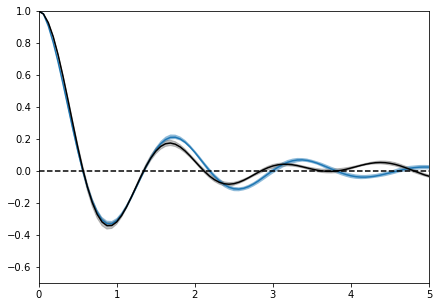

0


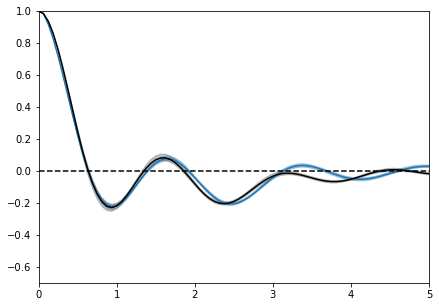

0


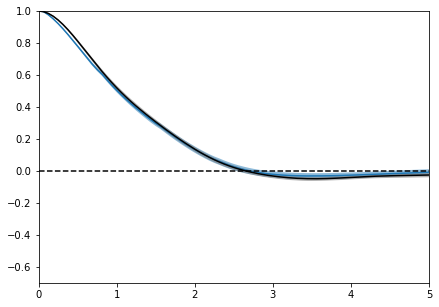

0


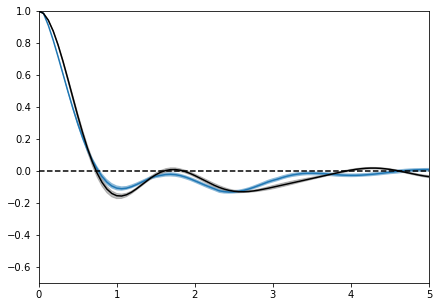

0


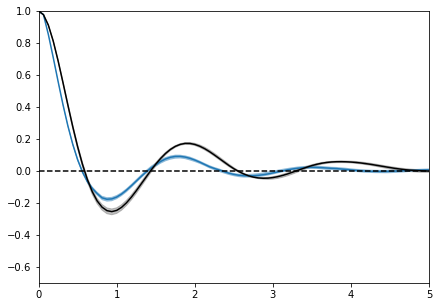

1


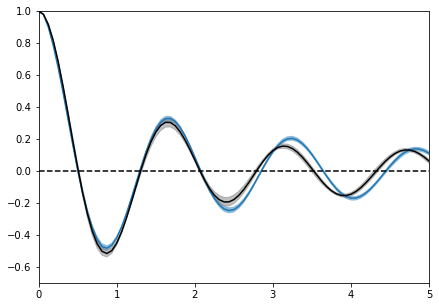

1


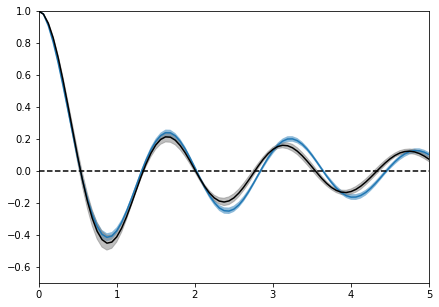

1


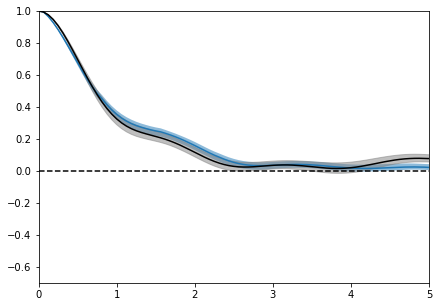

1


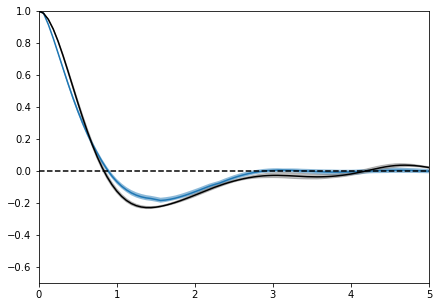

1


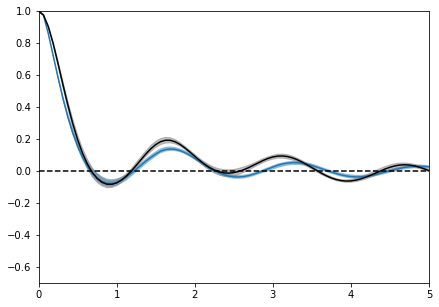

2


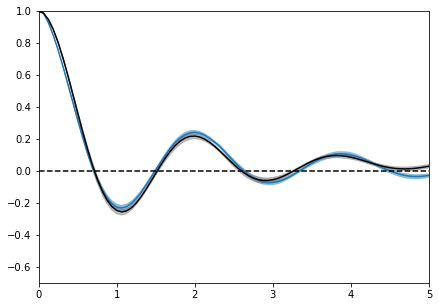

2


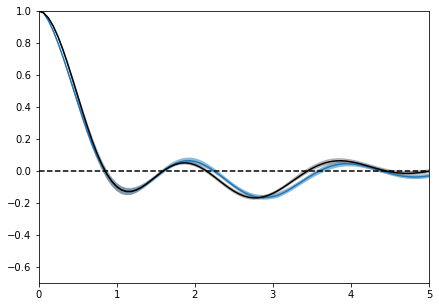

2


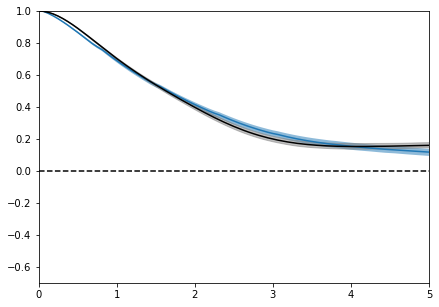

2


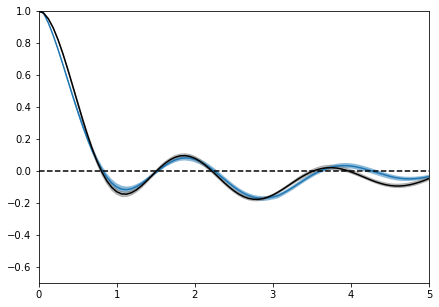

2


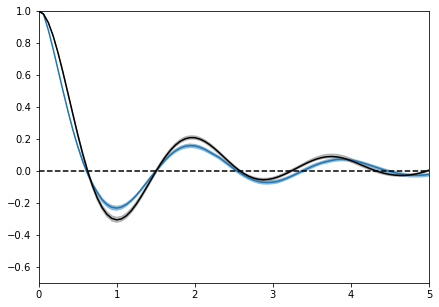

3


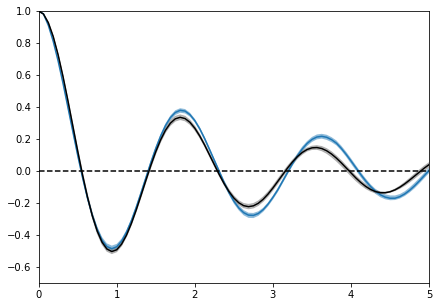

3


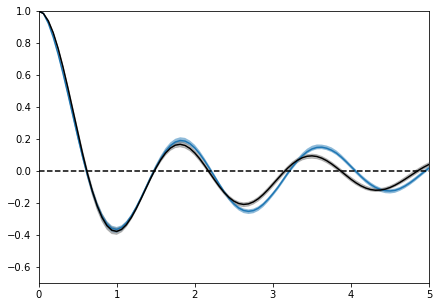

3


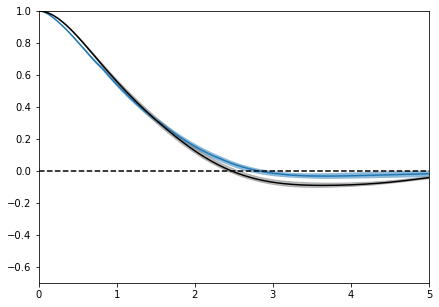

3


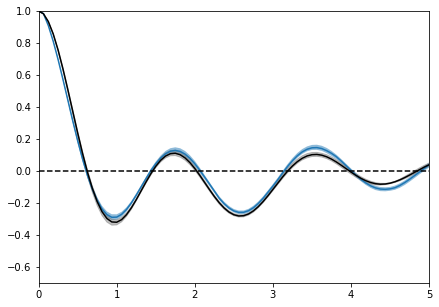

3


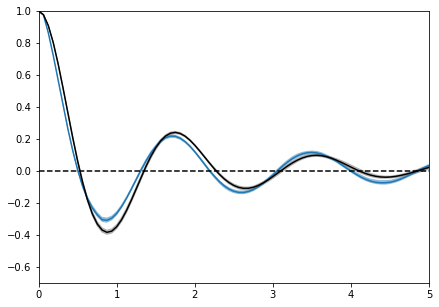

4


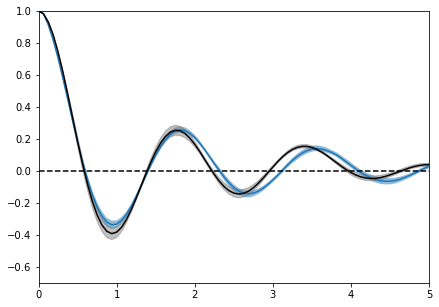

4


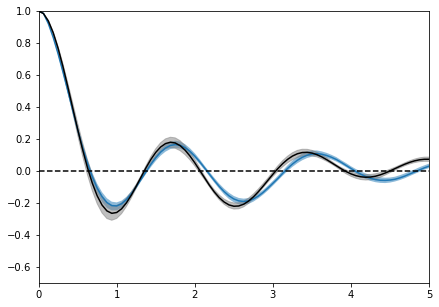

4


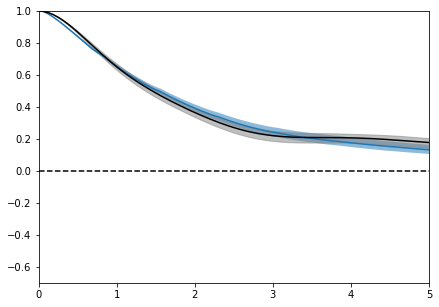

4


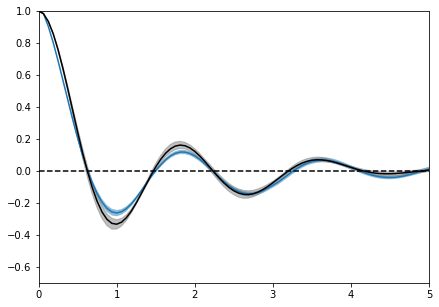

4


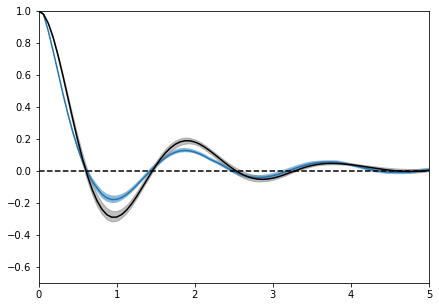

5


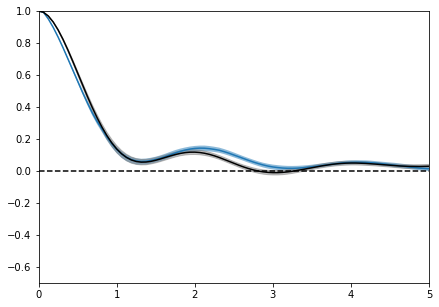

5


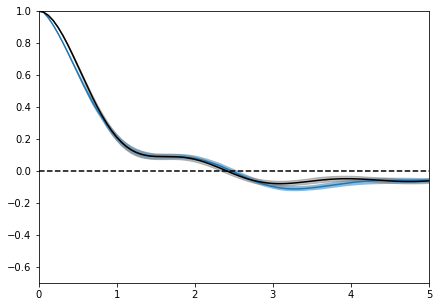

5


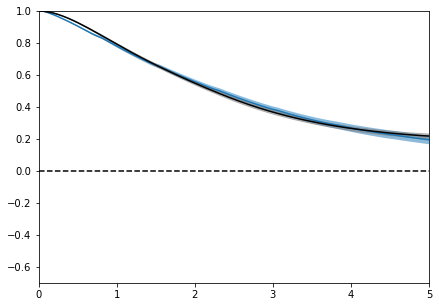

5


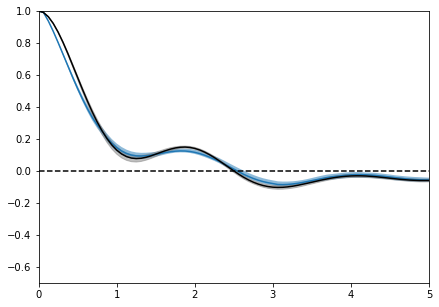

5


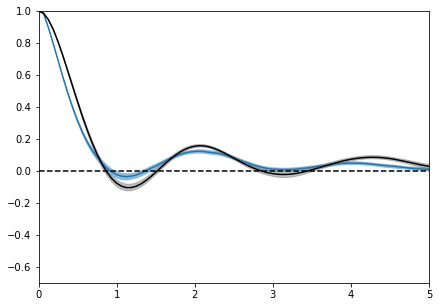

6


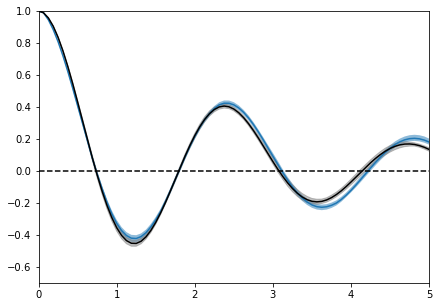

6


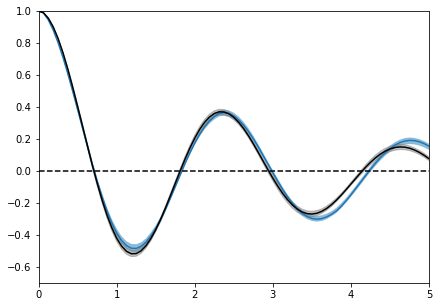

6


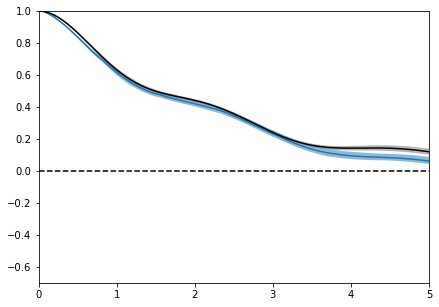

6


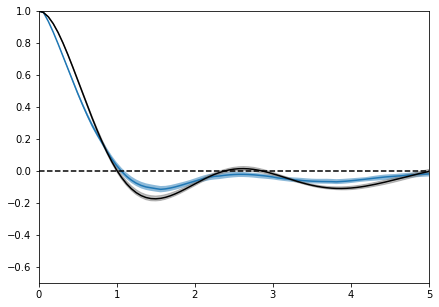

6


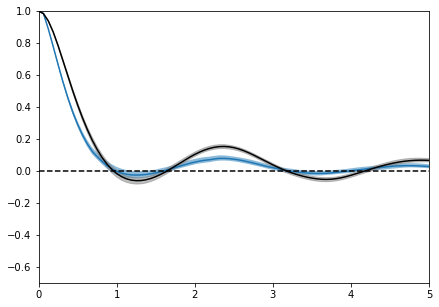

7


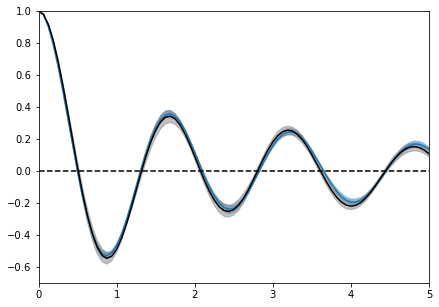

7


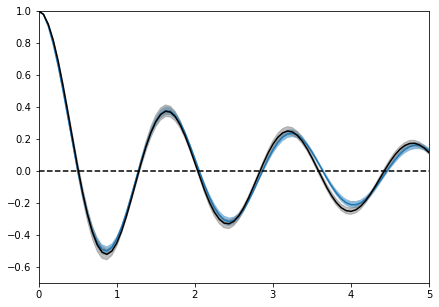

7


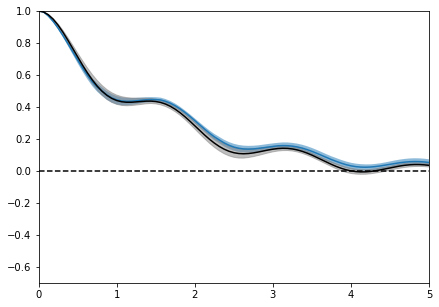

7


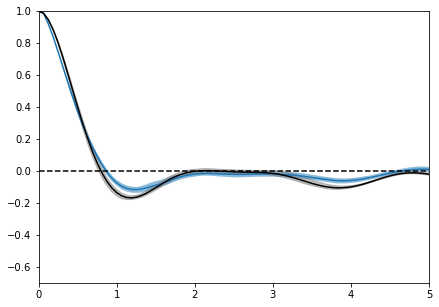

7


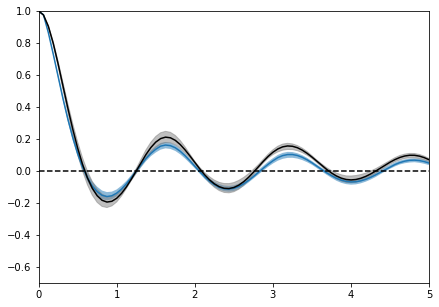

8


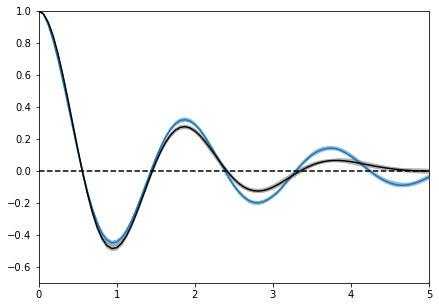

8


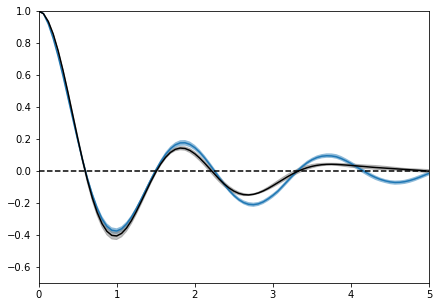

8


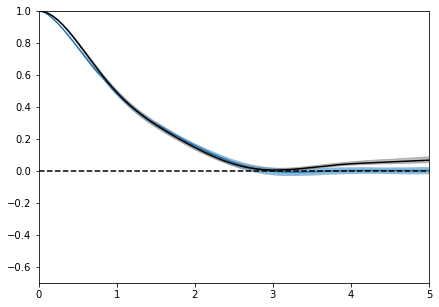

8


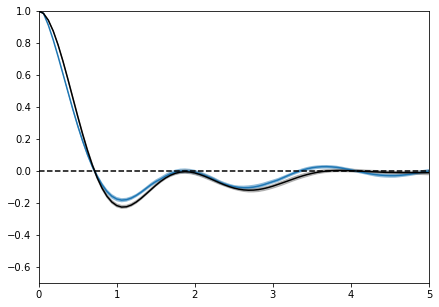

8


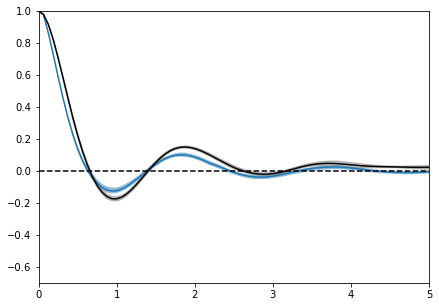

9


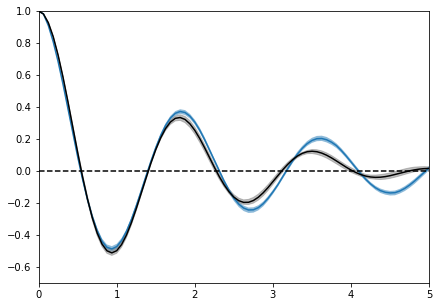

9


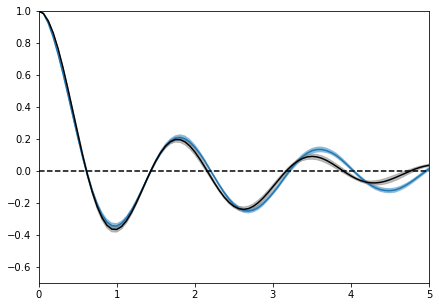

9


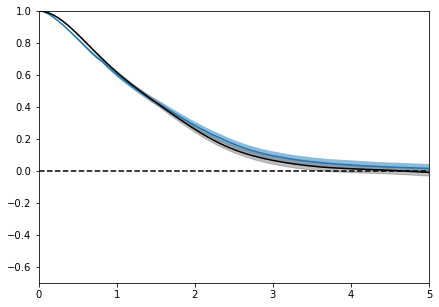

9


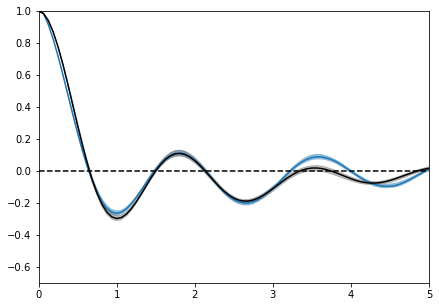

9


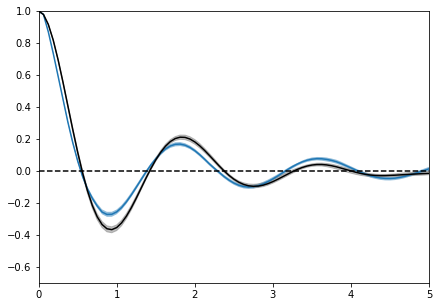

10


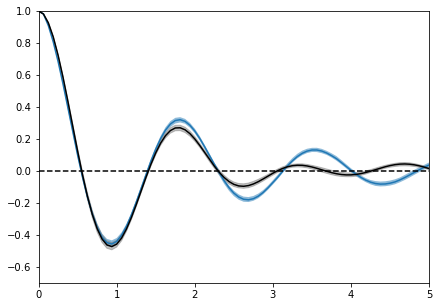

10


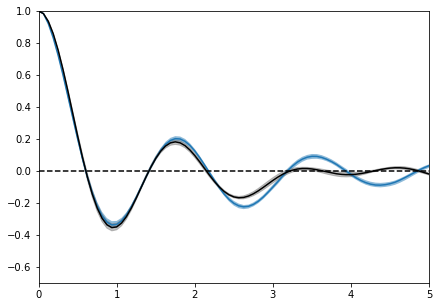

10


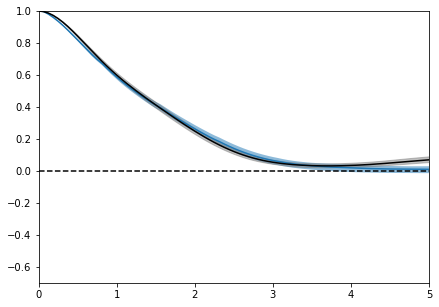

10


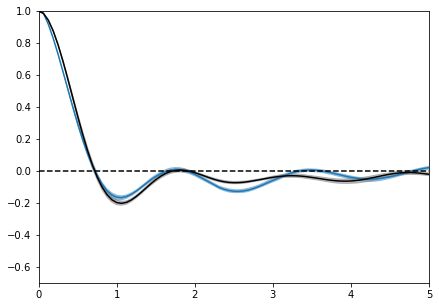

10


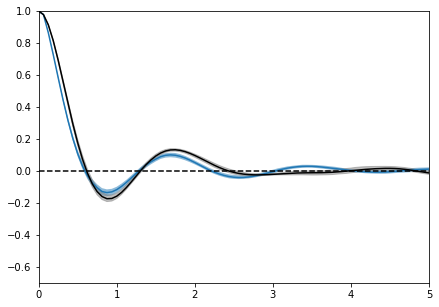

11


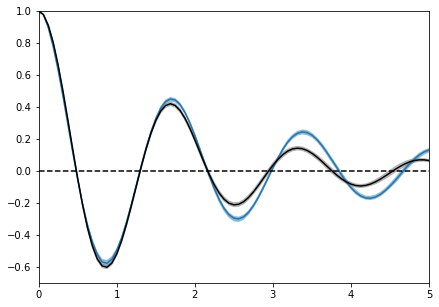

11


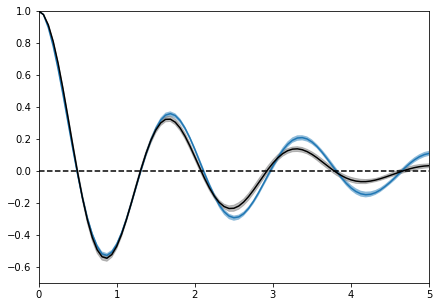

11


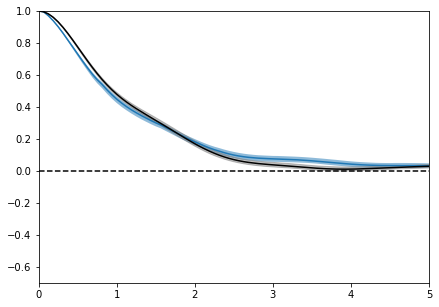

11


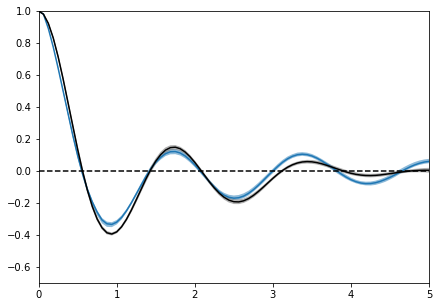

11


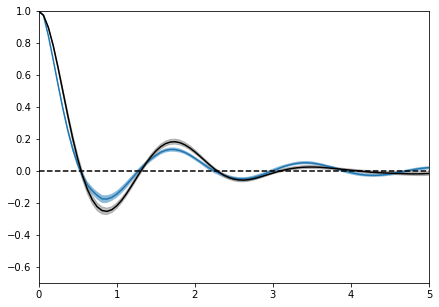

In [8]:
n_boot=100
for kw in range(n_worms):
    acfs_sims_seeds = acfs_sims_w[kw]
    acfs_data_seeds = acfs_data_w[kw]
    for km in range(5):
        print(kw)
        plt.figure(figsize=(7,5))
        acfs_sims_mean = np.array([np.array(acfs_sims_seeds)[np.random.randint(0,50,50),np.random.randint(100),:,km].mean(axis=0) for k in range(n_boot)])
        cil_sim = np.percentile(acfs_sims_mean,2.5,axis=0)
        ciu_sim = np.percentile(acfs_sims_mean,97.5,axis=0)
        mean_sim = np.vstack(acfs_sims_seeds)[:,:,km].mean(axis=0)
        mean_data,cil_data,ciu_data = stats.bootstrap(np.array(acfs_data_seeds)[:,:,km],n_times=100)
        plt.plot(lags*dt,mean_sim)
        plt.fill_between(lags*dt,cil_sim,ciu_sim,alpha=.5)
        plt.plot(lags*dt,mean_data,c='k')
        plt.fill_between(lags*dt,cil_data,ciu_data,alpha=.5,color='gray')
        plt.xlim(0,5)
        plt.ylim(-.7,1)
        plt.axhline(0,ls='--',c='k')
#         plt.savefig('acfs_w_ratio_{:.1f}_{}_mode_{}_bootstrap_both.pdf'.format(train_ratio,kw,km))
        plt.show()

# Events

In [9]:
rates_sims_w=[]
rates_data_w=[]
for kw in range(n_worms):
    indices = np.arange(len(l))[l[:,0]==kw]
    rates_sims_seed = []
    rates_data_seed = []
    for idx in indices:
        f = h5py.File('../data/cross_validate_events/events_train_ratio_{:.1f}_{}.h5'.format(train_ratio,idx),'r')
        dt_rates_data = np.array(f['dt_rates_data'])[0]
        vt_rates_data = np.array(f['vt_rates_data'])[0]
        rev_rates_data = np.array(f['rev_rates_data'])[0]
        dt_rates_sim = np.array(f['dt_rates_sim'])
        vt_rates_sim = np.array(f['vt_rates_sim'])
        rev_rates_sim = np.array(f['rev_rates_sim'])
        f.close()
        rates_sims_seed.append(np.vstack([vt_rates_sim,dt_rates_sim,rev_rates_sim]))
        rates_data_seed.append(np.vstack([vt_rates_data,dt_rates_data,rev_rates_data]))
    rates_sims_w.append(rates_sims_seed)
    rates_data_w.append(rates_data_seed)

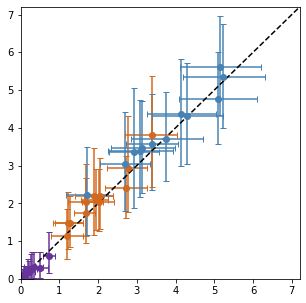

In [12]:
#across seeds
plt.figure(figsize=(5,5))
for kw in range(n_worms):
    rates_sims_seed = rates_sims_w[kw]
    rates_data_seed = rates_data_w[kw]
    for kstate in range(3):
        mean_sim,cil_sim,ciu_sim = np.mean(rates_sims_seed,axis=0)[kstate]
        mean,cil,ciu = np.mean(rates_data_seed,axis=0)[kstate]
        plt.errorbar(mean,mean_sim,xerr = [[mean-cil],[ciu-mean]],yerr = [[mean_sim-cil_sim],[ciu_sim-mean_sim]],c=colors_states_[kstate],marker='o',capsize=3)
xrange = np.linspace(0,10)
plt.plot(xrange,xrange,c='k',ls='--')
plt.xlim(0,7.2)
plt.ylim(0,7.2)
# plt.savefig('event_rates_all_worms_ratio_{:.1f}.pdf'.format(train_ratio))
plt.show()


0


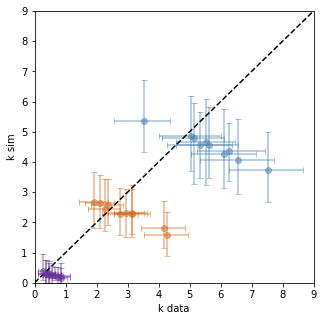

1


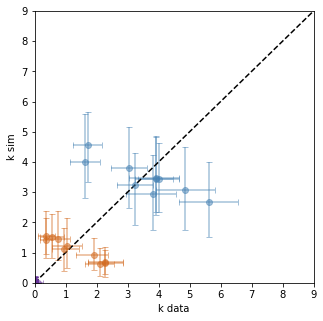

2


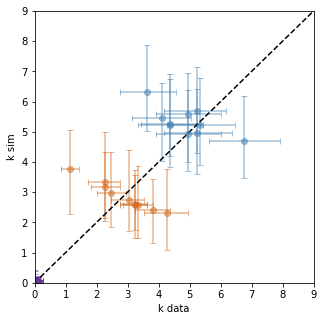

3


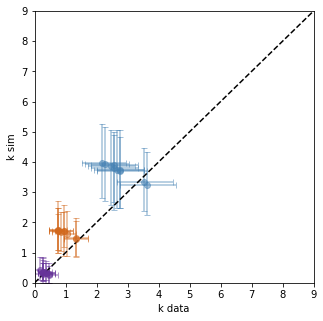

4


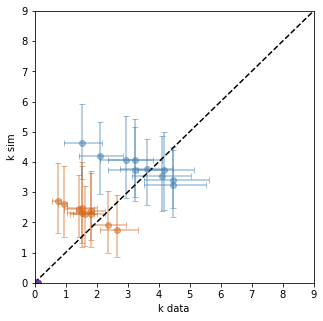

5


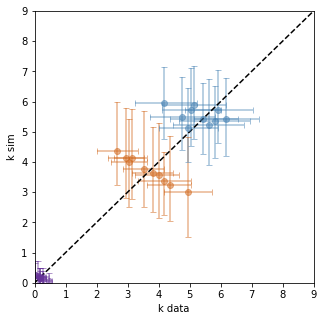

6


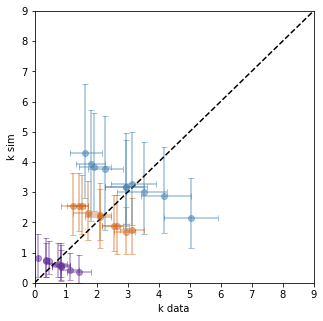

7


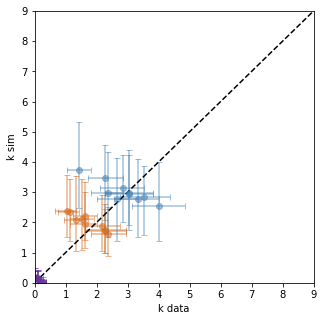

8


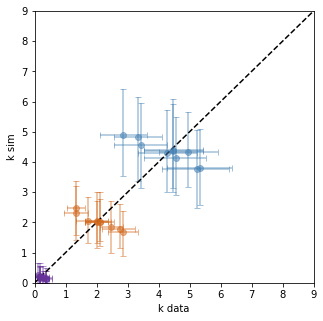

9


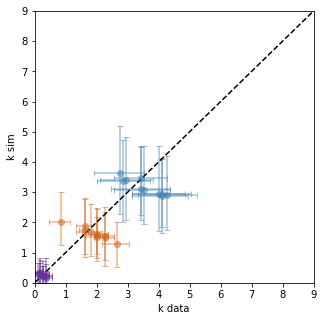

10


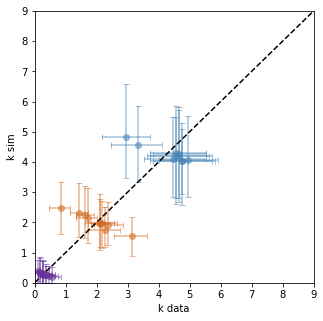

11


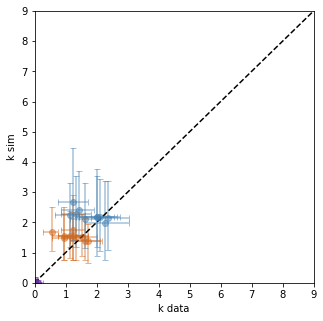

In [13]:
#per seed
colors_states_ = ['chocolate','rebeccapurple','steelblue']
states = ['ventral turns','dorsal turns','reversals']

for kw in range(n_worms):
    print(kw)
    plt.figure(figsize=(5,5))

    rates_sims_seed = rates_sims_w[kw]
    rates_data_seed = rates_data_w[kw]
    for kstate in range(3):
        for kseed in range(10):
            mean_sim,cil_sim,ciu_sim = rates_sims_seed[kseed][kstate]
            mean,cil,ciu = rates_data_seed[kseed][kstate]
            plt.errorbar(mean,mean_sim,xerr = [[mean-cil],[ciu-mean]],yerr = [[mean_sim-cil_sim],[ciu_sim-mean_sim]],c=colors_states_[kstate],alpha=.5,marker='o',capsize=3)

    xrange = np.linspace(0,10)
    plt.plot(xrange,xrange,c='k',ls='--')
    plt.xlabel('k data')
    plt.ylabel('k sim')
    plt.xlim(0,9)
    plt.ylim(0,9)
    plt.show()

# Transition rates

In [14]:
rates_sims_w=[]
rates_data_w=[]
for kw in range(n_worms):
    indices = np.arange(len(l))[l[:,0]==kw]
    rates_sims_seed=[]
    rates_data_seed=[]
    for idx in indices:
        f = h5py.File('../data/cross_validate_dts/dts_train_ratio_{:.1f}_{}.h5'.format(train_ratio,idx),'r')
        rates_sims = np.array(f['rates_sims'])
        rates_data = np.array(f['rates_data'])
        f.close()
        rates_sims_seed.append(rates_sims)
        rates_data_seed.append(rates_data)
    rates_sims_w.append(rates_sims_seed)
    rates_data_w.append(rates_data_seed)

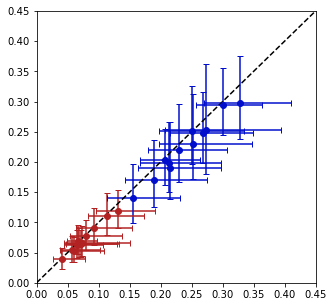

In [15]:
#across seeds
colors_state_ = ['#010fcc','firebrick']

plt.figure(figsize=(5,5))
for kw in range(n_worms):
    rates_sims_seed = rates_sims_w[kw]
    rates_data_seed = rates_data_w[kw]
    for kstate in range(2):
        mean_sim,cil_sim,ciu_sim = np.mean(rates_sims_seed,axis=0)[kstate]
        mean,cil,ciu = np.mean(rates_data_seed,axis=0)[kstate]
        plt.errorbar(mean,mean_sim,xerr = [[mean-cil],[ciu-mean]],yerr = [[mean_sim-cil_sim],[ciu_sim-mean_sim]],c=colors_state_[kstate],marker='o',capsize=3)
xrange = np.linspace(0,.6)
plt.plot(xrange,xrange,c='k',ls='--')
plt.xlim(0,.45)
plt.ylim(0,.45)
# plt.savefig('run_pirouette_rates_ratio_{:.1f}.pdf'.format(train_ratio))
plt.show()


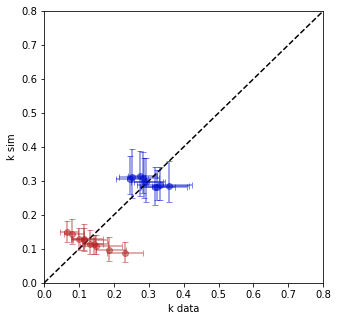

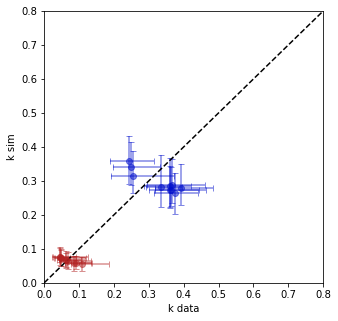

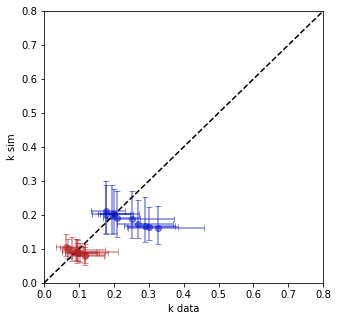

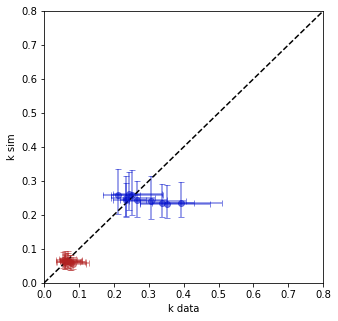

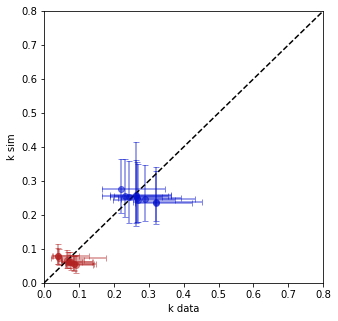

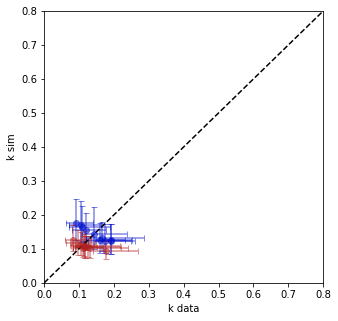

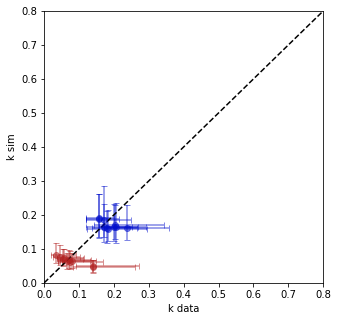

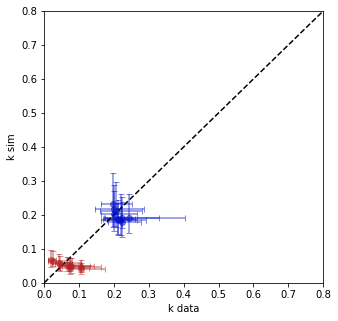

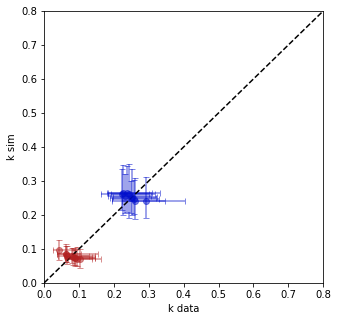

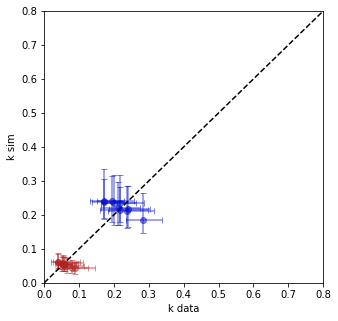

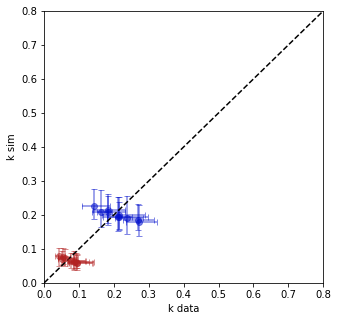

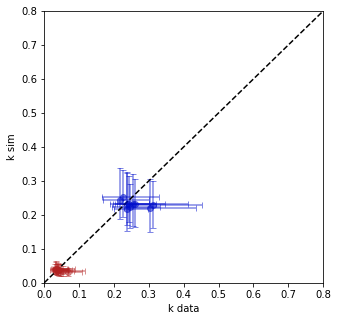

In [16]:
#per seed
for kw in range(n_worms):
    plt.figure(figsize=(5,5))
    rates_sims_seed = rates_sims_w[kw]
    rates_data_seed = rates_data_w[kw]
    for kstate in range(2):
        for kseed in range(10):
            mean_sim,cil_sim,ciu_sim = rates_sims_seed[kseed][kstate]
            mean,cil,ciu = rates_data_seed[kseed][kstate]
            plt.errorbar(mean,mean_sim,xerr = [[mean-cil],[ciu-mean]],yerr = [[mean_sim-cil_sim],[ciu_sim-mean_sim]],c=colors_state_[kstate],alpha=.5,marker='o',capsize=3)
    xrange = np.linspace(0,0.9)
    plt.plot(xrange,xrange,c='k',ls='--')
    plt.xlabel('k data')
    plt.ylabel('k sim')
    plt.xlim(0,.8)
    plt.ylim(0,.8)
    plt.show()